# Challenge: OpenQAOA
### Team # 32
### Team Members
- Ayelen Perez | Argentina
- Jefferson Granizo | Ecuador
- Jesus Montemayor | Perú
- Rubén Guzman | México
- Andres Diaz | Puerto Rico

# Problem Definition - Tic-Tac-Toe
Introduction
Tic-tac-toe, also known as noughts and crosses or Xs and Os, is a classic paper-and-pencil game for two players. The game is typically played on a 3x3 grid, although variations with larger grids exist. The objective of the game is simple: one player tries to get three of their marks (either X or O) in a row, either horizontally, vertically, or diagonally, before their opponent does. Consider you want to play the classic version in a 3x3 grid, that you are the "X"s, and that you want to design a winning strategy. Consider also the following convention:

the state of the X's is |1>
the state of the O's is |0>
the state of the empty cells in an unknown state.
Consider each bit of the tic-tac-toe board is represented by a qubit, in the form:
```
| q0 | q1 | q2 |
|----|----|----|
| q3 | q4 | q5 |
|----|----|----|
| q6 | q7 | q8 |
```

We can convert this problem into a binary optimization problem, known as QUBO (Quadratic unconstrained binary optimization) in order to use known Quantum Approximate Optimization (QAOA) Algorithms. We first create a cost function, that can be of the form:

$$𝐶(𝑞𝑖)=𝑀(𝑞_0+𝑞_1+𝑞_2+𝑞_3+𝑞_4+𝑞_5+𝑞_6+𝑞_7+𝑞_8−2)^2−(𝑞_0+𝑞_1+𝑞_2)^2−(𝑞_3+𝑞_4+𝑞_5)^2−(𝑞_6+𝑞_7+𝑞_8)^2−(𝑞_0+𝑞_3+𝑞_6)^2−(𝑞_1+𝑞_4+𝑞_7)^2−(𝑞_2+𝑞_5+𝑞_8)^2−(𝑞_0+𝑞_4+𝑞_8)^2−(𝑞_2+𝑞_4+𝑞_6)^2$$

The idea is to minimize this function when you get three X's in a row (vertical, horizontal, or diagonal), represented by the terms that are being subtracted. We do have the challenge of considering each of the possibilities of our opponent, and the order of play. We chose this well-know problem in order to learn how to apply QAOA and its different options (different simulation methods, inclusion of noise, etc) to a case where the minimum-energy state can be readily verified.

## Analysis of a toy problem - case # 1

To better understand how we can design a winning strategy and determine the best possibilities to win, we are going to consider the situation in the figure below. Your turn is next and we need to develop a quantum algorithm to be able to find the best decisions with the higher probability.

```
|  X |  O |  O |
|----|----|----|
|  X |    |    |
|----|----|----|
|  O |    |    |
```

We can then define a quantum state $|q_0q_1q_2q_3>$ made up of four qubits, each one representing the state of the four missing spaces:

```
|  X |  O |  O |
|----|----|----|
|  X | q0 | q1 |
|----|----|----|
|  O | q2 | q3 |
```

Consider now all the possible ways to win (eight in total: 3 vertical, 3 horizontal, and 2 diagonal). Of this eight possibilities, only two of them (second row horizontal and diagonal from the top right), are possible with the current stay of play, simplifying the definiton of our cost function. Our cost function $C$ now becomes:

$$C(q_i) = M(1+0+0+1+q_0+q_1+0+q_2+q_3-2)^2-(1+q_0+q_1)^2-(1+q_0+q_3)^2$$
$$C(q_i) = M(q_0+q_1+q_2+q_3)^2-(1+q_0+q_1)^2-(1+q_0+q_3)^2 $$

We now proceed to consider constraints, determined by the dynamics of the game and that we don't want our opponent to win.

**Equality Constraints**

From the order of play, we are missing at most two X's and two O's. Since we are playing the X's and we have two more plays, we have the condition:

$$q_0+q_1+q_2+q_3 = 2$$

Note that by incorporating this condition into our Cost function, we can further simplify it to:

$$C(q_i) = 4M -(1+q_0+q_1)^2-(1+q_0+q_3)^2 $$

where we choose $M$ to our convenience. Note the equality constraint still needs to be enforced, to guarantee there are exactly two X's in the missing squares.

**Inequality Constraints**

We can also prevent our opponent from winning by not allowing him to place an 'O' in the center square. We can represent this by requiring:

$$q_0 > 0$$

We can try to run the program with or without this inequality constraint to see what happens.

## Analysis of a toy problem - case # 2
A variation of case 1 is to consider starting one step earlier with your opponent not having chosen yet, as shown below. We can choose this option by calling the function `Problem` with input parameter '2'.

```
|  X |  O |  O |
|----|----|----|
|  X |    |    |
|----|----|----|
|    |    |    |
```

We can then define a quantum state $|x_0x_1x_2x_3x_4>$ made up of four qubits, each one representing the state of the four missing spaces:

```
|  X |  O |  O |
|----|----|----|
|  X | q0 | q1 |
|----|----|----|
| q4 | q2 | q3 |
```

## Process
The problem has been solved using the following workflow:
- Part 1: problem definition in function `Problem` using the QUBO implementation described above. The problem is then converted to an Ising Model and solved using QAOA.
- Part 2: improvement of the QAOA algorithm, considering other simulation methods: statevector_simulator, shot-based simulator, and annealing parameterization
- Part 3: implementation of the model using a Noise Model.
- Part 4: the different model are compared by plotting the cost function

#  Part 1 Problem definition and solution using QAOA

In [ ]:
%matplotlib notebook

# Import external libraries to present an manipulate the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import docplex model to generate the problem to optimize
from docplex.mp.model import Model

# Import the libraries needed to employ the QAOA quantum algorithm using OpenQAOA
from openqaoa import QAOA

# method to covnert a docplex model to a qubo problem
from openqaoa.problems.converters import FromDocplex2IsingModel #check this method and properties
from openqaoa.backends import create_device

# method to find the correct states for the QAOA object
from openqaoa.utilities import ground_state_hamiltonian

Code your problem

In [ ]:
# inputs

def Problem(value): #(values,weights, max_weight):

    # initialize a model
    mdl = Model("Basic Problem using minimize")

    if value == 1:
        #tic-tac-toe with only 4 cells left empty
        #|  X |  O |  O |
        #|  X | q0 | q1 |
        #|  O | q2 | q3 |
        # indicate the binary variables
        n_vars = 4 # Number of variables
        q = mdl.binary_var_list(n_vars, name="q")
        # define the objective function
        obj_func = 40 - (1+q[0]+q[1])*(1+q[0]+q[1]) - (1+q[0]+q[3])*(1+q[0]+q[3])
        mdl.minimize(obj_func)
        # add the constraints
        mdl.add_constraint(q[0] + q[1] + q[2] + q[3] == 2)
        #mdl.add_constraint(q[0] >= 0)
    elif value == 2:
        #tic-tac-toe with 5 cells left empty
        #|  X |  O |  O |
        #|  X | q0 | q1 |
        #| q4 | q2 | q3 |
        # indicate the binary variables
        n_vars = 5 # Number of variables
        q = mdl.binary_var_list(n_vars, name="q")
        # define the objective function
        obj_func = 40 - (2+q[4])*(2+q[4]) -(q[2]+q[3]+q[4])*(q[2]+q[3]+q[4]) - (1+q[0]+q[1])*(1+q[0]+q[1]) - (1+q[0]+q[3])*(1+q[0]+q[3])
        mdl.minimize(obj_func)
        # add the constraints
        mdl.add_constraint(q[0] + q[1] + q[2] + q[3] + q[4] == 2)
        #mdl.add_constraint(q[0] >= 0)
    # print a summary of the docplex model
    # print(mdl.prettyprint())

    return mdl #return model, check FromDocplex2IsingModel


In [ ]:
# Ising encoding of the QUBO problem
mdl = Problem(1)
qubo = FromDocplex2IsingModel(mdl)
ising_encoding = qubo.ising_model
# Docplex encoding of the QUBO problem
mdl_qubo_docplex = qubo.qubo_docplex

mdl_qubo_docplex.prettyprint()
# Print in a df the ising encoding (we need to remove keys: 'problem_instance' and 'metadata'))
#ising_encoding_dict = ising_encoding.asdict(exclude_keys=['problem_instance', 'metadata'])
#pd.DataFrame(ising_encoding_dict)

// This file has been generated by DOcplex
// model name is: Basic Problem using minimize
// var contrainer section
dvar bool q[4];

// single vars section
dvar bool q_0;
dvar bool q_1;
dvar bool q_2;
dvar bool q_3;

minimize
 - 72 q_0 - 70 q_1 - 68 q_2 - 70 q_3 [ 15 q_0^2 + 32 q_0*q_1 + 34 q_0*q_2
 + 32 q_0*q_3 + 16 q_1^2 + 34 q_1*q_2 + 34 q_1*q_3 + 17 q_2^2 + 34 q_2*q_3
 + 16 q_3^2 ] + 106;
 
subject to {

}


<IPython.core.display.Javascript object>


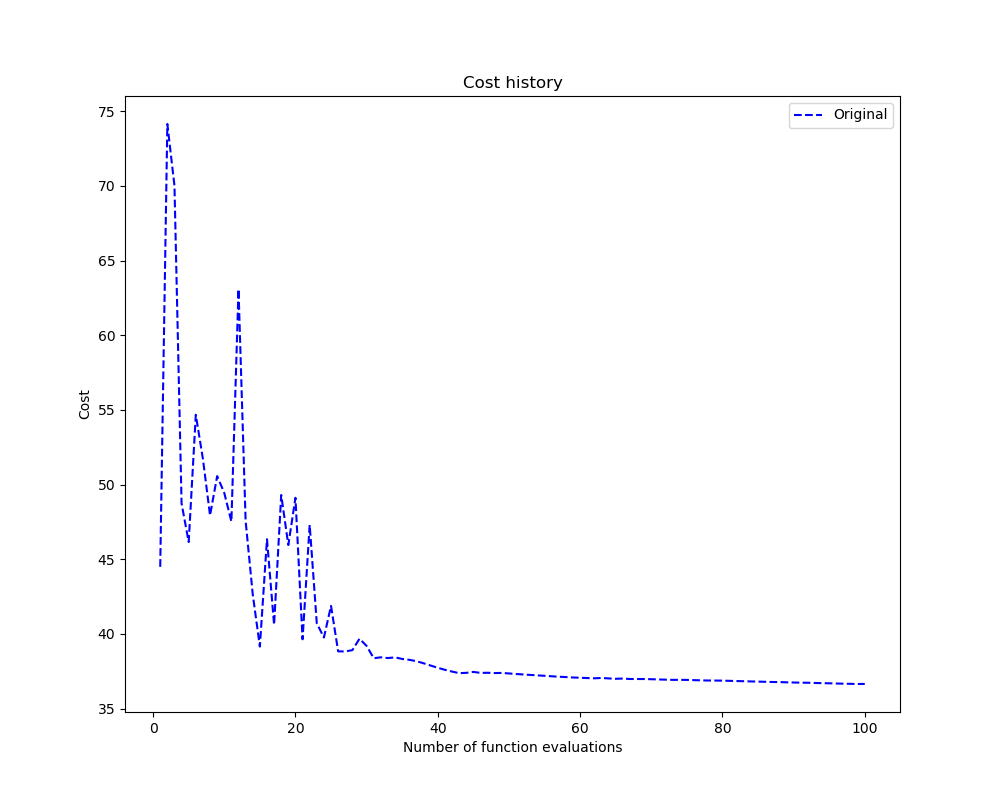

,solutions_bitstrings,bitstrings_energies,probabilities
0,1100,27.0,0.119885
1,1001,27.0,0.119885
2,1010,32.0,0.113245
3,0101,32.0,0.112614
4,0110,35.0,0.111264


In [ ]:
# Initialize the QAOA object
qaoa = QAOA()

# Set the parameters to use the QAOA algorithm
qaoa.set_backend_properties(n_shots=1024, seed_simulator=1)
# p=1, a custom type and range from 0 to pi
qaoa.set_circuit_properties(p=2, init_type="custom", variational_params_dict={"betas":2*[0.01*np.pi],"gammas":2*[0.01*np.pi]})
#Indicate the ising e ncoding model from docplex
qaoa.compile(ising_encoding)
# Run the QAOA algorithm
qaoa.optimize()

results_qaoa = qaoa.result
results_qaoa.plot_cost(label='Original')
pd.DataFrame(qaoa.result.lowest_cost_bitstrings(5))

In [ ]:
# To find the correct answer using ground_state_hamiltonian
# and the parameter is a cost_hamiltonian
correct_solution = ground_state_hamiltonian(qaoa.cost_hamil)
correct_solution

(27.0, ['1100', '1001'])

Validate your answer using docplex, you can see how to check the classical solution using the following tutorial [here](https://github.com/entropicalabs/openqaoa/blob/main/examples/community_tutorials/02_docplex_example.ipynb)

In [ ]:
## docplex solution
sol = mdl_qubo_docplex.solve()
mdl_qubo_docplex.print_solution(print_zeros=True)

objective: 27.000
status: OPTIMAL_SOLUTION(2)
  q_0=1
  q_1=1
  q_2=0
  q_3=0


# Part 2: Improve the QAOA circuit

Perform the same process as above now with the variant of using different backends, p values, and different optimizers until you find the one that can provide the correct answers with the least number of iterations, quantum circuit depth.

Optimized cost with AnnealingParams: 36.69610068004


<IPython.core.display.Javascript object>


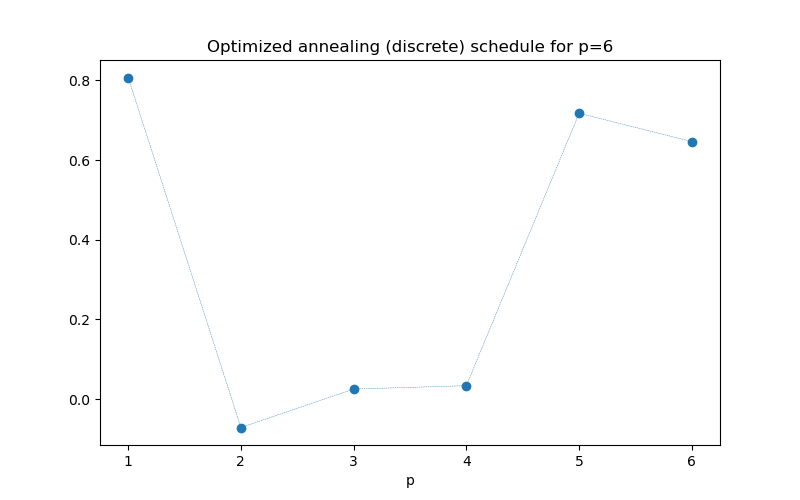

In [ ]:
## Implementation

# Modeling with statevector_simulator
q_sv = QAOA()
qiskit_sv = create_device(location='local', name='qiskit.statevector_simulator')
q_sv.set_device(qiskit_sv)
q_sv.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')
q_sv.set_classical_optimizer(method='COBYLA', maxiter=400, tol=0.001, cost_progress=True, parameter_log=True)

q_sv.compile(ising_encoding)
q_sv.optimize()
results_sv = q_sv.result
#pd.DataFrame(q_sv.result.lowest_cost_bitstrings(5))

# Modeling with shot-based simulator
q_shot = QAOA()
qiskit_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_shot.set_device(qiskit_shot)
q_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')
q_shot.set_backend_properties(n_shots = 400)
q_shot.set_classical_optimizer(method='COBYLA', maxiter=400, tol=0.001, cost_progress=True, parameter_log=True)

q_shot.compile(ising_encoding)
q_shot.optimize()
results_shot = q_shot.result
pd.DataFrame(q_shot.result.lowest_cost_bitstrings(5))

# Modeling with annealing parameterization
q_annealing = QAOA()
p=6
q_annealing.set_circuit_properties(p=p, param_type='annealing', init_type='ramp')
q_annealing.set_classical_optimizer(maxiter=100)
q_annealing.compile(ising_encoding)
q_annealing.optimize()
results_annealing = q_annealing.result
print("Optimized cost with AnnealingParams:", q_annealing.result.optimized['cost'])
# annealing optimized schedule
opt_schedule = q_annealing.result.optimized['angles']
p_i = range(1,p+1)
fig = plt.figure(figsize=(8,5))
plt.plot(p_i,opt_schedule,lw=0.3,ls='--',marker='o')
plt.xlabel('p')
plt.title(f'Optimized annealing (discrete) schedule for p={p}');


# Part 3: Noise Model

The optimal combination that you found with the best optimizer, the lowest number of $p$'s and the correct answer, can give the same answer with noise, use the circuit with a noise model and identify if it gives the same answer.

In [ ]:
# implementation using a noise model using qiskit
from qiskit.providers.fake_provider import FakeManila
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator

# Modeling with noisy shot-based simulator
device_backend = FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)

q_noisy_shot = QAOA()
qiskit_noisy_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_noisy_shot.set_device(qiskit_noisy_shot)
q_noisy_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')
q_noisy_shot.set_backend_properties(n_shots = 200, noise_model = noise_model)
q_noisy_shot.set_classical_optimizer(method='COBYLA', maxiter=400, tol=0.001, cost_progress=True, parameter_log=True)

q_noisy_shot.compile(ising_encoding)
q_noisy_shot.optimize()
results_noisy_shot = q_noisy_shot.result
pd.DataFrame(q_noisy_shot.result.lowest_cost_bitstrings(5))

,solutions_bitstrings,bitstrings_energies,probabilities
0,1100,27.0,0.005
1,1001,27.0,0.010
2,0101,32.0,0.140
3,1010,32.0,0.095
4,0110,35.0,0.140


# Part 4: Model comparison

<IPython.core.display.Javascript object>


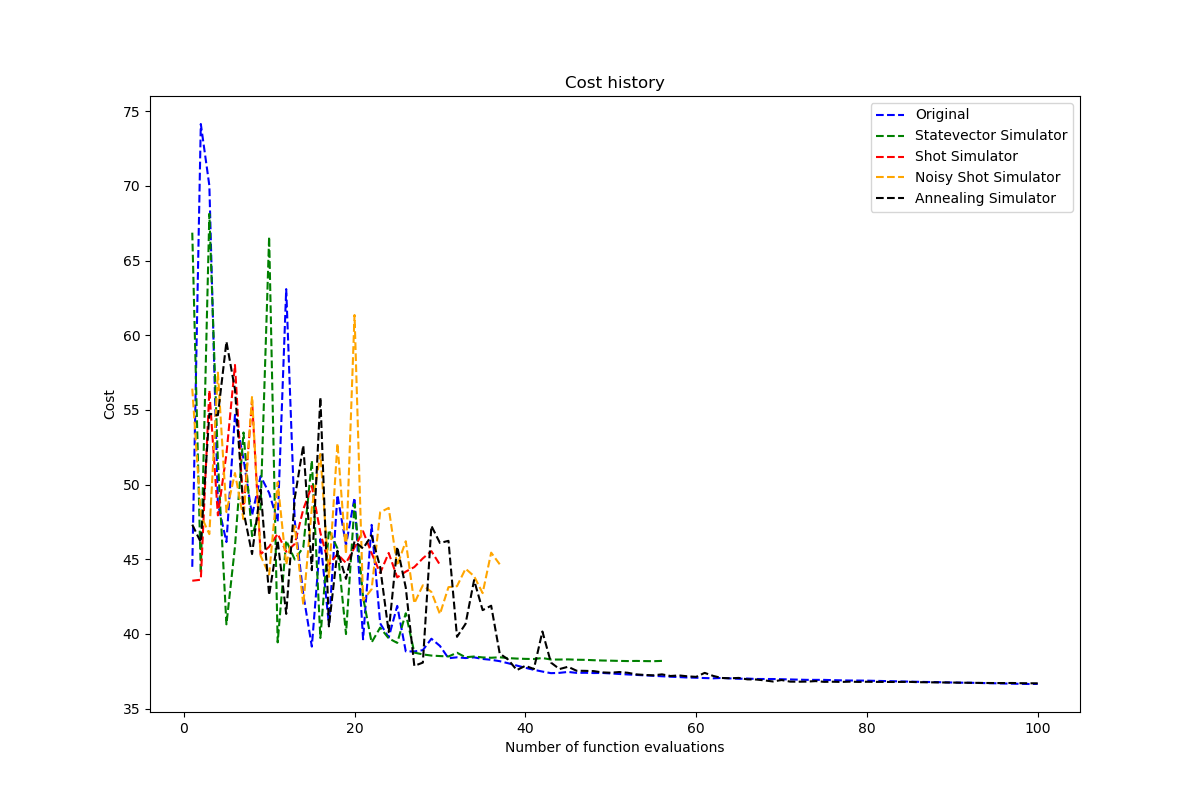

In [ ]:
# Print figure comparing results
fig, ax = plt.subplots(1,1,figsize=(12,8))
results_qaoa.plot_cost(ax=ax,label='Original')
results_sv.plot_cost(ax=ax,color='green',label='Statevector Simulator')
results_shot.plot_cost(ax=ax,color='red',label='Shot Simulator')
results_noisy_shot.plot_cost(ax=ax,color='orange',label='Noisy Shot Simulator')
results_annealing.plot_cost(ax=ax,color='black',label='Annealing Simulator')

# Acknowledgments

🎉🎉🎉

Special thanks to Entropica Labs for helping us create this challenge and being able to use their SDK, OpenQAOA. If you want to know more about OpenQAOA or ask them questions directly, check out their [discord channel](discord.gg/ana76wkKBd).

🎉🎉🎉